[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/estadistica/blob/main/trabajo2/trabajo2.ipynb)

In [28]:
# Bibliotecas necesarias
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import bartlett, shapiro
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from IPython.display import display, Markdown

# Trabajo 2

## Base de datos

### Carga y analisis simple de la base de datos

La base de datos con la que le corresponde trabajar, se obtiene como una muestra aleatoria que corresponde a corresponde a los resultados obtenidos por los jóvenes de todo el país en las pruebas Saber 11, del año 2022. La información aparece agregada por Colegio y solo abarca los colegios de Antioquia. Dicha base contiene las variables: NATURALEZA (Colegio Oficial o No-Oficial), JORNADA (Asociado a los diferentes tipos de jornada de estudio), PROMLECT (Promedio obtenido por el colegio en Lectura Crítica) y PROMMATE (Promedio obtenido por el colegio en Matemáticas).

In [6]:
# Leer archivo csv

raw_data_url = "https://raw.githubusercontent.com/repos-especializacion-UdeA/estadistica/refs/heads/main/trabajo2/DatosTrabajo2EAE20242.csv"

# Leer el archivo CSV
df = pd.read_csv(raw_data_url)

# Mostrar las primeras filas del DataFrame
df.head()

,NATURALEZA,JORNADA,PROMLECT,PROMMATE
0,OFICIAL,COMPLETA,33,18
1,OFICIAL,COMPLETA,0,19
2,OFICIAL,COMPLETA,30,21
3,OFICIAL,COMPLETA,44,21
4,OFICIAL,COMPLETA,31,25


### Funciones resumen

In [7]:
[f,c] = df.shape
print(f"Cantidad de datos: {f}")
print(f"Caracteristicas: {c}")

Cantidad de datos: 1807
Caracteristicas: 4


In [8]:
# Información resumida de los datos numericos
df.describe()

,PROMLECT,PROMMATE
count,1807.000000,1807.000000
mean,50.321527,47.105147
std,7.028032,7.897110
min,0.000000,18.000000
25%,45.000000,41.000000
50%,50.000000,47.000000
75%,55.000000,52.000000
max,74.000000,76.000000


In [9]:
# Informacion sobre los datos
df.value_counts()

NATURALEZA  JORNADA        PROMLECT  PROMMATE
OFICIAL     UNICA          53        49          10
            COMPLETA       44        41          10
            MANANA         56        52           9
NO OFICIAL  COMPLETA       63        63           9
OFICIAL     FIN DE SEMANA  43        39           9
                                                 ..
            COMPLETA       44        30           1
                                     34           1
                                     44           1
                           45        29           1
            UNICA          65        64           1
Length: 964, dtype: int64

In [10]:
# Cantidad de datos nulos
df.isnull().sum()

NATURALEZA    0
JORNADA       0
PROMLECT      0
PROMMATE      0
dtype: int64

In [11]:
# Datos categoricos
print(df.NATURALEZA.unique())
print(df.JORNADA.unique())

['OFICIAL' 'NO OFICIAL']
['COMPLETA' 'MANANA' 'UNICA' 'NOCTURNA' 'FIN DE SEMANA' 'TARDE']


## Punto 1 - Intervalo de confianza

Construir en Python un IC para al 95% de confianza necesario para responder: ¿Puede afirmarse que el resultado medio obtenido por los colegios en Lectura es superior a 45 puntos? Justifique su respuesta.

### Solución

Sea **$X_i$** la VA relacionada con el promedio obtenido en la prueba de lectura critica por el i-esimo colegio 

A partir de la tabla podemos obtener los siguientes valores:

In [12]:
# Datos del problema
data_prom_lectura = df.PROMLECT.copy()

# Calculo de la media y la desviacion estandar muestral
n = data_prom_lectura.shape[0]
X = data_prom_lectura.mean()
S = data_prom_lectura.std()

# Despliegue de los resultados
print(f"n = {n}")
print(f"X = {X:.5f}")
print(f"S = {S:.5f}")


n = 1807
X = 50.32153
S = 7.02803


Como la poblacion no es normal, el numero de datos que esta tiene es de mas de 30 y la varianza es desconocida, usamos la siguiente formula para el intervalo de confianza:

$$
IC = \overline{X}\pm Z_{\alpha/2}\frac{S}{\sqrt{n}}
$$

Inicialmente vamos a calcular para $\alpha = 0.05$:

$
Z_{\alpha/2} = Z_{0.025}  
$

In [13]:
NC = 95 # Nivel de confianza
alpha = 1 - NC/100 

Z = stats.norm().ppf(1 - alpha/2)
print(f"Z = {Z:.5f}")

EBM = Z*S/np.sqrt(n)
print(f"EBM = {EBM:.5f}")

IC_left = X - EBM 
IC_right = X + EBM
print(f"({X:.5f} - {EBM:.5f},{X:.5f} + {EBM:.5f})= ({IC_left:.5f},{IC_right:.5f})")

Z = 1.95996
EBM = 0.32404
(50.32153 - 0.32404,50.32153 + 0.32404)= (49.99748,50.64557)


> ### Conclusión 
> Como el intervalo en el cual se encuentra la media para prueba de lectura está en el rango (49.998,50.646) se puede afirmar con un nivel de confianza del 95% que el resultado promedio en la prueba de lectura es superior a 45 puntos. Esto se puede ver por qué el límite inferior del intervalo de confianza es 49.997 (mayor que 45) o en otras palabras el valor de 45 puntos no está dentro del intervalo de confianza. 
> 
> Así, en resumen, dado que todo el intervalo está por encima de 45 puntos, podemos concluir que es muy poco probable que el promedio verdadero sea igual o menor a 45 puntos. Por lo tanto, podemos afirmar que el promedio es superior a 45 puntos con un alto nivel de confianza.


## Punto 2 - Prueba de hipotesis

¿Se puede afirmar que el resultado medio obtenido por los colegios en Matemáticas es mayor en los Privados que en los Públicos? Justifique su respuesta mediante una prueba de hipótesis con una significancia del 4%.

In [14]:
# Informacion de la prueba de matematicas 

# Instituciones publicas
notas_mat_publico = df[df['NATURALEZA'] == 'OFICIAL']['PROMMATE'].copy()
# Instituciones privadas
notas_mat_privado = df[df['NATURALEZA'] == 'NO OFICIAL']['PROMMATE'].copy()

Se tienen las siguientes VA:
* Sea **$X_i$** la VA relacionada con el promedio obtenido en la prueba de matematicas por el i-esimo colegio privado
* Sea **$Y_i$** la VA relacionada con el promedio obtenido en la prueba de matematicas por el j-esimo colegio publico

In [15]:
# Colegio privado
nx = notas_mat_privado.shape[0]
X = notas_mat_privado.mean()
Sx = notas_mat_privado.std()
print(f"nx = {nx}")
print(f"X = {X:.5f}")
print(f"Sx = {Sx:.5f}")

nx = 341
X = 52.75367
Sx = 9.59462


In [16]:
# Colegio publico
ny = notas_mat_publico.shape[0]
Y = notas_mat_publico.mean()
Sy = notas_mat_publico.std()
print(f"ny = {ny}")
print(f"Y = {Y:.5f}")
print(f"Sy = {Sy:.5f}")

ny = 1466
Y = 45.79127
Sy = 6.80895


Hipotesis: Enunciado: $\mu_x > \mu_y$ es decir $\mu_x - \mu_y > 0$

* $H_o: \mu_x - \mu_y \leq 0$
* $H_a: \mu_x - \mu_y > 0$

Calculo del estadistico de prueba

In [17]:
d0 = 0
Zc = (X - Y - d0) / ((Sx**2 / nx + Sy**2 / ny)**0.5)
print(f"Zc = {Zc:.5f}")

Zc = 12.67807


In [18]:
VP = 1 - stats.norm.cdf(Zc)
print(f"VP = {VP:e}")

VP = 0.000000e+00


In [19]:
# Nivel de significancia
alpha = 0.04 # 4%

# Paso 4 - Si VP <= a, se rechaza la hipotesis nula, para un a = 0.04
print(VP <= alpha)

True


> ### Conclusión
> Como $VP <\alpha \longrightarrow 0.00 < 0.04$ se rechaza la hipótesis nula $H_0$ aceptándose la hipótesis alternativa $H_a$ de modo que podemos decir con un nivel de significación del 4% que el resultado medio en las pruebas de Matemáticas es mejor en los colegios privados que en los públicos, esto es $\mu_1-\mu_2>0$.

## Punto 3 - Regresión lineal

Analice si hay una relación lineal entre las variables Promedio obtenido por el colegio en Lectura Crítica y Promedio obtenido por el colegio en Matemáticas, mediante una regresión lineal con todos sus repecivos componentes.

### Obtencion del modelo

Inicialmente se obtienen los datos y se hace un diagrama de dispersión para visualizar gráficamente la relación entre estos. Para este caso se definieron estos de la siguiente manera:
* Variable independiente ($x$): Nota promedio de la prueba de lectura crítica para cada colegio.
* Variable dependiente ($y$): Nota promedio de la prueba de matemáticas para cada colegio.


In [37]:
# Preparar los datos (PROMLECT como variable independiente X y PROMMATE como variable dependiente y)
promedio_notas = df.iloc[:][['PROMLECT','PROMMATE']].copy()
x = promedio_notas.PROMLECT
y = promedio_notas.PROMMATE

#### Grafico de dispersion

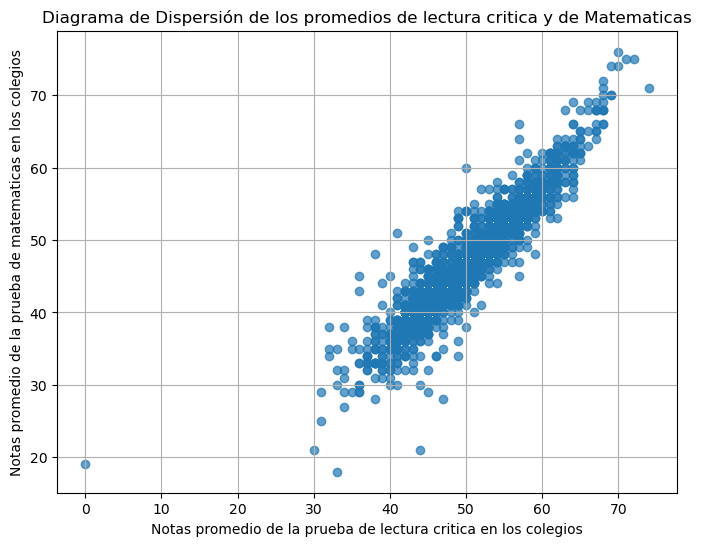

In [38]:
# Crear un diagrama de dispersión entre PROMLECT y PROMMATE
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)

# Añadir etiquetas y título
plt.title('Diagrama de Dispersión de los promedios de lectura critica y de Matematicas')
plt.xlabel('Notas promedio de la prueba de lectura critica en los colegios')
plt.ylabel('Notas promedio de la prueba de matematicas en los colegios')

# Mostrar el gráfico
plt.grid(True)
plt.show()

#### Modelo de regresion lineal

In [72]:
# 1. Preparar los datos
X = x.values.reshape(-1, 1)  # Variable independiente
Y = y.values  # Variable dependiente

# 2. Crear el modelo de regresión lineal
modelo = LinearRegression()

# 3. Ajustar el modelo a los datos
modelo.fit(X, Y)

# 4. Obtener el coeficiente y la intersección
B1 = modelo.coef_[0]  # Coeficiente de la regresión
B0 = modelo.intercept_  # Intersección (ordenada al origen)

print(f'Pendiente (B1): {B1}')
print(f'Intersepto (B0): {B0}')

Pendiente (B1): 1.046945295837803
Intersepto (B0): -5.578739732057144


De acuerdo a los resultados anteriores, el modelo lineal será:

$$Y = \beta_0+ \beta_1X = -5.5787+ 1.0469X$$

A continuación, se muestra la comparación del modelo lineal obtenivo con los datos reales de la grafica de dispersión

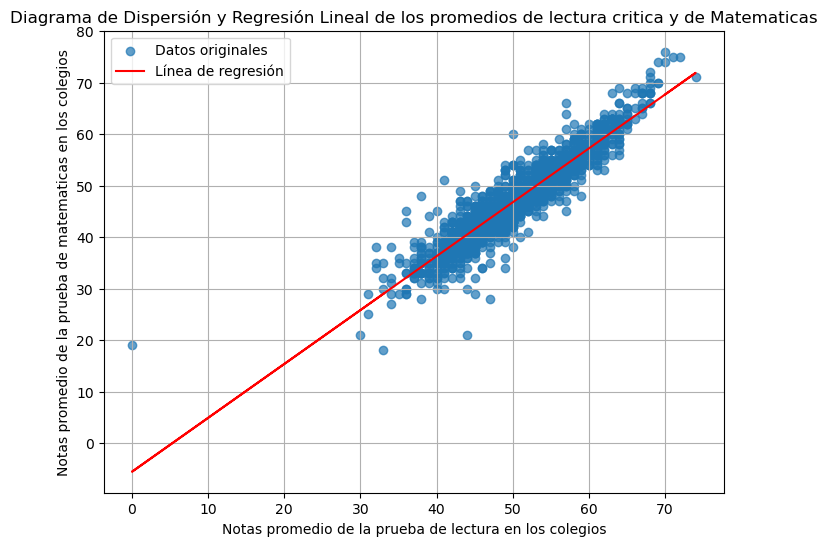

In [98]:
# 1. Predecir los valores de y para graficar la línea de regresión
Y_pred = modelo.predict(X)

# 2. Graficar el diagrama de dispersión y la línea de regresión
plt.figure(figsize=(8, 6))

# 2.1. Diagrama de dispersión
plt.scatter(X, Y, alpha=0.7, label='Datos originales')

# 2.2. Línea de regresión
plt.plot(X, Y_pred, color='red', label='Línea de regresión')

# 2.3. Añadir etiquetas y título
plt.title('Diagrama de Dispersión y Regresión Lineal de los promedios de lectura critica y de Matematicas')
plt.xlabel('Notas promedio de la prueba de lectura en los colegios')
plt.ylabel('Notas promedio de la prueba de matematicas en los colegios')
plt.legend()
plt.grid(True)

# 2.4. Mostrar el gráfico
plt.show()

### Analisis del modelo

#### Coeficiente de determinación

Para calcular el coeficiende de determinación se emplea la siguiente expresión:

$$R^2 = \frac{SCE}{SCT} = \frac{SCE}{SCE+SCR} = 1 - \frac{SCE}{SCR}$$

Donde:

|Metrica|Expresión|
|----|----|
|Suma de Cuadrados Residuales (SCR)|$SCR = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$|
|Suma de Cuadrados Explicada (SCE)|$SCE = \sum_{i=1}^{n} (\hat{y}_i - \bar{y})^2$|
|Suma Total de Cuadrados (SCT)|$SCT = \sum_{i=1}^{n} (y_i - \bar{y})^2$|




In [74]:
# Calculo SCT, SCR y SCE

# SCE: Suma de cuadrados explicada
SCE = np.sum((Y_pred - np.mean(Y)) ** 2)

# SCR: Suma de cuadrados residuales
SCR = np.sum((Y - Y_pred) ** 2)

# SCT: Suma total de cuadrados
SCT = np.sum((Y - np.mean(Y)) ** 2)

# R2
R2 = 1 - (SCR / SCT)

# 2. Despliegue de las metricas
print(f"SCE: {SCE}")
print(f"SCR : {SCR}")
print(f"SCT: {SCT}")
print(f"R^2: {R2}")

SCE: 97776.22062943572
SCR : 14853.801506701551
SCT: 112630.02213613724
R^2: 0.868118631027635


Como el valor de $R^2 = 0.8681$ aproximadamente el 86.8% de la variabilidad en el rendimiento en matemáticas (PROMMATE) puede explicarse por el rendimiento en lectura (PROMLECT) según este modelo de regresión.

#### Coeficiente de correlación


$$r = \frac{S_{xy}}{\sqrt{S_{xx} S_{yy}}} = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2\sum_{i=1}^{n} (y_i - \bar{y})^2 }} $$

$$r = \left(signo\;de\;\hat{\beta_1}\right)\sqrt{R^2} $$

In [46]:
r = np.sqrt(R2)
print(f"Coeficiente de correlación (r): {r:.5f}")

Coeficiente de correlación (r): 0.93173


Como el valor del coeficiente de correlación $r = 0.93173 > 0.7$, hay una relación lineal fuerte entre el rendimiento en la lectura y el rendimiento en matematicas. Como a medida que la primera aumenta, la segunda tambien lo hace la relación es directa.

### Supuestos del modelo

En un análisis de regresión se empieza por hacer un supuesto acerca del modelo apropiado para la relación entre las variables dependientes e independientes. En el caso de la regresión lineal simple, se supone que el modelo de regresión es

$$Y = \beta_0 + \beta_1X + \epsilon$$


Sin embargo, aun cuando se obtenga un valor grande para $R^2$, la ecuación de regresión estimada no debe ser usada sino hasta que se realice un análisis para determinar si el modelo empleado es apropiado. Un paso importante para ver si el supuesto del modelo es adecuado, consiste en probar la signifi cancia de la relación. Las pruebas de significancia en el análisis de regresión están basadas en los siguientes supuestos acerca del término del error $\epsilon$.

1. $E(\epsilon) = 0$
2. $Var(\epsilon) = \sigma^2 = cte$
3. Los valores de $\epsilon$ con independientes (no estan correlacionados).
4. El término del error $\epsilon$ es una variable aleatoria distribuida normalmente.

A continuación vamos a proceder a la validación de los supuestos

#### Aleatoriedad

Para el caso lo que vamos a probar es lo siguiente:

**Hipótesis**:
* $H_0: corr(\epsilon_i,\epsilon_j) = 0$ (Los errores **son independientes** entre sí, es decir no hay autocorrelación).
* $H_a: corr(\epsilon_i,\epsilon_j) \neq 0$ (Los errores **no son independientes** entre sí, o sea que estan correlacionados).

Dependiendo de los valores que toma el estadístico de Durbin-Watson en el rango [0,4] se llegan a las siguientes conclusiones:
* Si el valor está cercano a 2, los errores son independientes (no hay autocorrelación).
* Si el valor está cercano a 0, hay autocorrelación positiva.
* Si el valor está cercano a 4, hay autocorrelación negativa.

In [97]:
residuos = Y - Y_pred

# Aplicar el test de Durbin-Watson
dw_stat = durbin_watson(residuos)

print(f'Estadístico de Durbin-Watson: {dw_stat:.5f}')


Estadístico de Durbin-Watson: 0.73617


El valor del estadístico de Durbin-Watson para los residuos de este modelo es aproximadamente 0.73617 de modo que al ser este valore mas cercano a 0 los errores tienen **autocorrelación positiva**, de modo que  estos **no son independientes**.

#### Normalidad

Para el caso lo que vamos a probar es lo siguiente:

**Hipótesis**:
* $H_0: \epsilon_i \sim N$ (Los residuos **siguen** una distribución normal).
* $H_a: \epsilon_i \nsim N$ (Los errores **no siguen** una distribución normal).

**Regla de decisión**: Se rechaza $H_0$ si $VP < \alpha$

In [79]:
# Realizar la prueba de Shapiro-Wilk para los residuos
alpha = 0.05
shapiro_stat, shapiro_p_value = shapiro(residuos)

print(f'Estadístico de Shapiro-Wilk: {shapiro_stat:.5f}')
print(f'Valor p: {shapiro_p_value}')

if shapiro_p_value < alpha:
    print("Se rechaza H0 de modo que la distribución de los residuos no es normal")
else:
    print("Se acepta H0 de modo que la distribución de los residuos es normal")

Estadístico de Shapiro-Wilk: 0.94516
Valor p: 2.174988369826515e-25
Se rechaza H0 de modo que la distribución de los residuos no es normal


Como el valor p es mucho menor que $\alpha = 0.05$, se rechaza la hipótesis nula de que los residuos se distribuyen normalmente. Esto significa que podemos decir con un nivel de significancia del 5% que los residuales **no siguen una distribución normal**.

#### Varianza constante

Para el caso lo que vamos a probar es lo siguiente:

**Hipótesis**:
* $H_0: V[\epsilon_i] = \sigma^2$ (La varianza **es constante**)
* $H_a: V[\epsilon_i] \neq \sigma^2$ (La varianza **no es constante**)

**Regla de decisión**: Se rechaza $H_0$ si $VP < \alpha$



In [80]:
alpha = 0.05
X_with_const = sm.add_constant(X)

# Realizar el test de Breusch-Pagan
bp_test = het_breuschpagan(residuos, X_with_const)

# El test devuelve 4 valores: estadístico de Lagrange Multiplier, p-valor, estadístico f y p-valor f
bp_stat, bp_p_value, _, _ = bp_test

# Mostrar los resultados
print(f'Estadístico de Breusch-Pagan: {bp_stat}')
print(f'Valor p: {bp_p_value}')


if bp_p_value < alpha:
    print("Se rechaza H0 de modo que la varianza los residuos no es constante")
else:
    print("Se acepta H0 de modo que la varianza los residuos es constante")


Estadístico de Breusch-Pagan: 44.34894437598665
Valor p: 2.747601252492318e-11
Se rechaza H0 de modo que la varianza los residuos no es constante


Como el valor p es muy pequeño (mucho menor que $\alpha = 0.05$) se rechaza la hipotesis nula de homocedasticidad; por lo tanto, los residuos son **heterostaticos**, es decir que su varianza no es constante a lo largo de los datos.

#### Datos atipicos


$$MCE = \frac{SCE}{n - 2} = \frac{1}{n-2} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Fórmula para estandarizar los residuos:

Los residuos estandarizados se calculan utilizando la siguiente fórmula:

$$d_i = \frac{e_i}{s_e} = \frac{e_i}{\sqrt{MCE}}$$

Donde:
* $d_i$: es el residuo estandarizado para la observación 
* $e_i$: es el residuo ordinario para la observación $i$ (diferencia entre el valor observado y el valor predicho).
* $s_e$: es la desviación estándar de los residuos.

Aquellos datos cuya $\left|d_i \right| > 3$ son candidatos a ser tomados como datos atípicos. 

In [94]:
# Calcular la desviación estándar de los residuos
se = np.std(residuos, ddof=2)

# Estandarizar los residuos
residuos_estandarizados = residuos / se

# umbral 
umbral = 3

datos_atipicos = promedio_notas[np.abs(residuos_estandarizados) > umbral].copy()
datos_atipicos['d_i'] =  residuos_estandarizados[np.abs(residuos_estandarizados) > umbral]
datos_atipicos

,PROMLECT,PROMMATE,d_i
0,33,18,-3.824234
1,0,19,8.567999
3,44,21,-6.792998
7,47,28,-5.447717
13,45,29,-4.369206
19,44,30,-3.655653
35,45,32,-3.323424
71,49,34,-4.086071
96,47,35,-3.007560
122,49,36,-3.388883


### Graficas

#### Grafico de residuos

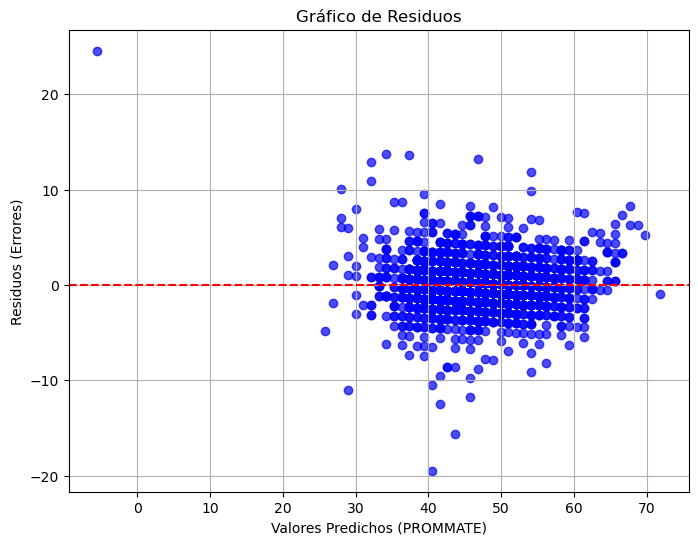

In [95]:
# 1. Calcular los residuos (errores)
residuos = Y - Y_pred

# 2. Graficar los residuos (errores) en función de los valores predichos
plt.figure(figsize=(8, 6))
plt.scatter(Y_pred, residuos, alpha=0.7, color='blue')

# 2.1. Dibujar una línea horizontal en y=0 para visualizar los errores
plt.axhline(0, color='red', linestyle='--')

# 2.2. Añadir etiquetas y título
plt.title('Gráfico de Residuos')
plt.xlabel('Valores Predichos (PROMMATE)')
plt.ylabel('Residuos (Errores)')
plt.grid(True)

# 2.3. Mostrar el gráfico
plt.show()

#### QQ plot

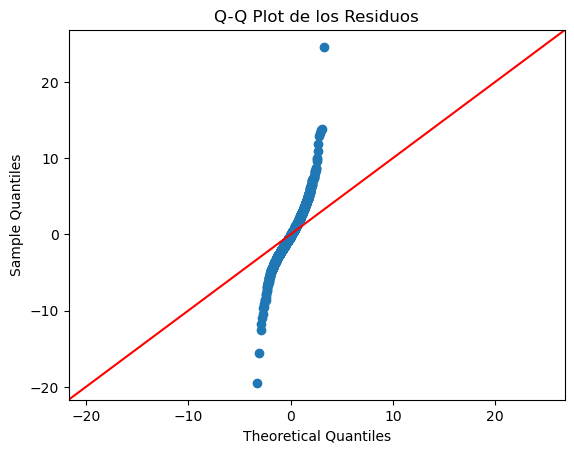

In [96]:
# Generar el Q-Q plot para visualizar la normalidad de los residuos
sm.qqplot(residuos, line ='45')
plt.title('Q-Q Plot de los Residuos')
plt.show()